In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from Bio.PDB import PDBParser
import os

import sys
sys.path.append('/Users/mads/Documents/Python/kermut/')
from src import BLAT_ECOLX_WT, ALPHABET
from src.experiments.investigate_correlations import show_example, load_protein_mpnn_outputs

In [6]:
# Compare KLD with Wasserstein distance
from scipy.stats import wasserstein_distance
from scipy.special import kl_div
from scipy.stats import entropy

In [104]:
def compare_sites():
    wd = os.getcwd()
    dataset = "BLAT_ECOLX"
    # Set paths
    data_path = Path(wd, "../", "data", "processed", f"{dataset}.tsv")
    surface_path = Path(wd, "../", "data", "processed", f"{dataset}_surface.csv")
    conditional_probs_path = Path(
        wd, "../",
        "data",
        "interim",
        dataset,
        "proteinmpnn",
        "conditional_probs_only",
        f"{dataset}.npz",
    )
    pdb_path = Path(wd, "../", "data", "raw", f"{dataset}.pdb")

    # Load assay and surface data
    df_assay = pd.read_csv(data_path, sep="\t")
    df_surface = pd.read_csv(surface_path)
    wt_seq = BLAT_ECOLX_WT

    # Process dataframe
    df_assay["wt_aa"] = df_assay["mut2wt"].str[0]
    df_assay["aa"] = df_assay["mut2wt"].str[-1]

    # Load PDB file using BioPython
    parser = PDBParser()
    structure = parser.get_structure(dataset, pdb_path)
    model = structure[0]
    chain = model["A"] # ???

    coords = np.array(
        [atom.get_coord() for atom in chain.get_atoms() if atom.get_name() == "CA"]
    )
    df_coords = pd.DataFrame(coords, columns=["x", "y", "z"])
    df_coords["pos"] = df_coords.index + 1

    # Compute pairwise distances
    distance_matrix = np.zeros((coords.shape[0], coords.shape[0]))
    for i in range(coords.shape[0]):
        for j in range(coords.shape[0]):
            distance_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])

    # Load and process conditional probabilities
    p_mean = load_protein_mpnn_outputs(conditional_probs_path)

    # Compute entropy of each position
    entropy = np.zeros(p_mean.shape[0])
    for i in range(p_mean.shape[0]):
        entropy[i] = -np.sum(p_mean[i] * np.log(p_mean[i]))

    # Get indices of distance_matrix where value < 5 and > 0
    idx_i, idx_j = np.where(distance_matrix < 5)
    idx_i, idx_j = idx_i[idx_i != idx_j], idx_j[idx_i != idx_j]

    # For all pairs, compute KL divergence and Wasserstein distance
    kl_divergence = np.zeros(idx_i.shape[0])
    kl_divergence_reverse = np.zeros(idx_i.shape[0])
    wasserstein_distance = np.zeros(idx_i.shape[0])
    JSD = np.zeros(idx_i.shape[0])

    for i in range(idx_i.shape[0]):
        kl_divergence[i] = np.sum(
            p_mean[idx_i[i]] * np.log(p_mean[idx_i[i]] / p_mean[idx_j[i]])
        )
        kl_divergence_reverse[i] = np.sum(
            p_mean[idx_j[i]] * np.log(p_mean[idx_j[i]] / p_mean[idx_i[i]])
        )
        wasserstein_distance[i] = 1-np.min(p_mean[[idx_i[i], idx_j[i]]], axis=0).sum()
        JSD[i] = 1/2 * np.sum(p_mean[idx_i[i]] * (np.log(p_mean[idx_i[i]]) - np.log(p_mean[[idx_i[i],idx_j[i]]].mean(axis=0)))) + 1/2 * np.sum(p_mean[idx_j[i]] * (np.log(p_mean[idx_j[i]]) - np.log(p_mean[[idx_i[i],idx_j[i]]].mean(axis=0))))

    # Collect in DataFrame
    wt_seq_arr = np.array(list(wt_seq))
    df_kl = pd.DataFrame(
        {
            "pos_i": idx_i + 1,
            "pos_j": idx_j + 1,
            "kl_divergence": kl_divergence,
            "kl_divergence_reverse": kl_divergence_reverse,
            "kl_divergence_sum": kl_divergence+kl_divergence_reverse,
            "wasserstein_distance": wasserstein_distance,
            "JSD": JSD,
            "entropy_i": entropy[idx_i],
            "entropy_j": entropy[idx_j],
            "distance": distance_matrix[idx_i, idx_j],
            "aa_i": wt_seq_arr[idx_i],
            "aa_j": wt_seq_arr[idx_j],
        }
    )

    # Filter out positions with no assay data
    df_kl = df_kl[
        (df_kl["pos_i"].isin(df_assay["pos"])) & (df_kl["pos_j"].isin(df_assay["pos"]))
    ]

    # Filter out positions with high KL divergence and low entropy
    # kl_median = df_kl["kl_divergence"].median()
    # entropy_median = df_kl["entropy_i"].median()
    # df_kl = df_kl[
    #     (df_kl["kl_divergence"] < kl_median)
    #     & (df_kl["entropy_i"] > entropy_median)
    #     & (df_kl["entropy_j"] > entropy_median)
    # ]

    # Sort by KL and inspect top pair
    df_kl = df_kl.sort_values(by="kl_divergence", ascending=True)

    return p_mean, df_assay, df_kl

In [115]:
p_mean, df_assay, df_kl = compare_sites()

<Axes: ylabel='Frequency'>

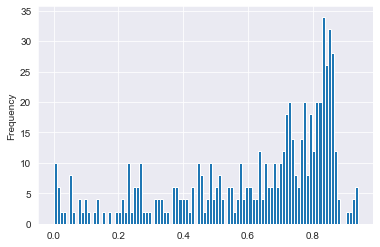

In [127]:
df_kl.wasserstein_distance.apply(lambda x: x**2).plot.hist(bins=100)

<Axes: ylabel='Frequency'>

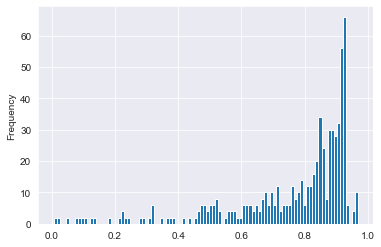

In [121]:
df_kl.wasserstein_distance.plot.hist(bins=100)

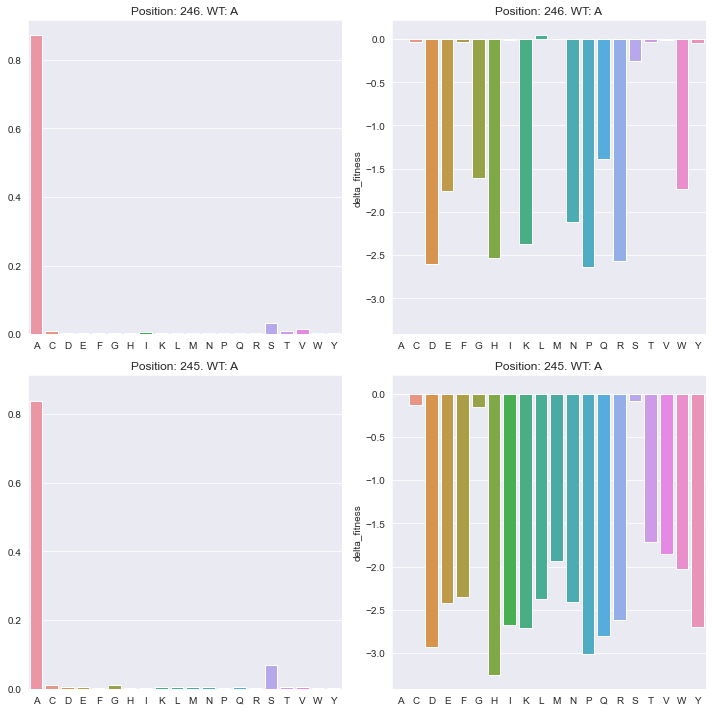

In [63]:
show_example(4, p_mean, df_assay, df_kl)

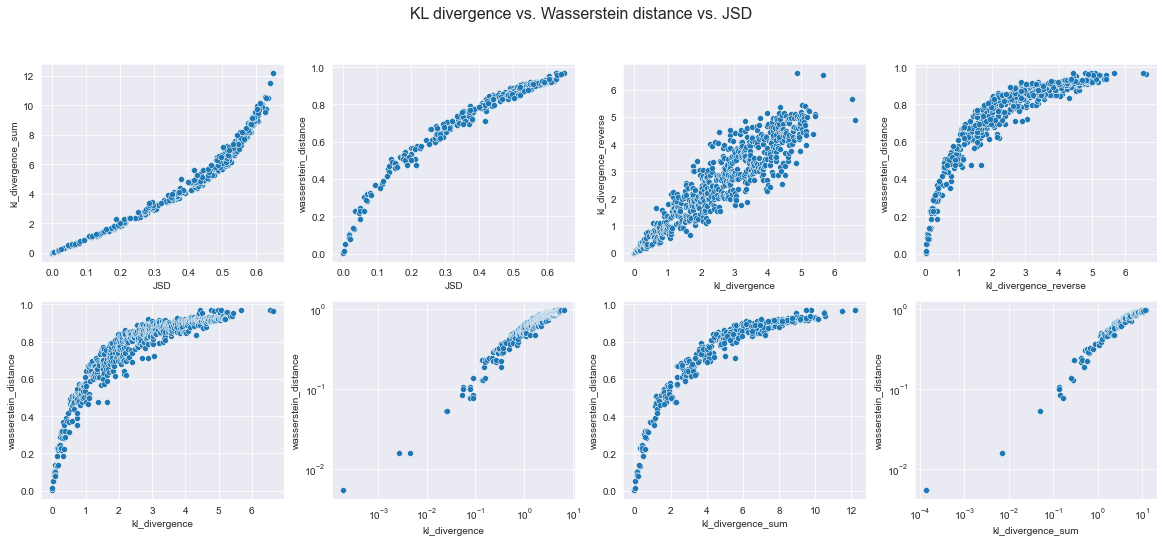

In [114]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 8))
sns.scatterplot(ax=ax[0,0], data=df_kl, x="JSD", y="kl_divergence_sum")
sns.scatterplot(ax=ax[0,1], data=df_kl, x="JSD", y="wasserstein_distance")

sns.scatterplot(ax=ax[0,2], data=df_kl, x="kl_divergence", y="kl_divergence_reverse")
sns.scatterplot(ax=ax[0,3], data=df_kl, x="kl_divergence_reverse", y="wasserstein_distance")

sns.scatterplot(ax=ax[1,0], data=df_kl, x="kl_divergence", y="wasserstein_distance")
sns.scatterplot(ax=ax[1,1], data=df_kl, x="kl_divergence", y="wasserstein_distance")
ax[1,1].set(xscale="log", yscale="log")

sns.scatterplot(ax=ax[1,2], data=df_kl, x="kl_divergence_sum", y="wasserstein_distance")
sns.scatterplot(ax=ax[1,3], data=df_kl, x="kl_divergence_sum", y="wasserstein_distance")
ax[1,3].set(xscale="log", yscale="log")
fig.suptitle("KL divergence vs. Wasserstein distance vs. JSD", fontsize=16)
plt.show()
